## One step approach


In [1]:
# Import
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import pandas as pd

import mlflow
import logging 
import config 

from basic_functions import (
    get_preprocess_data,
    get_lemmatized_data,
    get_metrics
)


/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setup

In [2]:
MODEL_NAME = "logistic_regression" 
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [3]:
DATA_PATH = "../data/data_multiclass_with_none_large.csv"

In [4]:
#setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag("mlflow.runName", "LogReg Multiclass Large")
mlflow.log_param("dataset", DATA_PATH)

Active run_id: 454c25a1e9304f52827db49bcb3a694c


'../data/data_multiclass_with_none_large.csv'

### Model Initialization

In [5]:
df = get_preprocess_data(DATA_PATH)
df = get_lemmatized_data(df)

X = df['text']
y = df['logical_fallacies']
# y = df['two_class_target']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # Bigrams (or even trigrams)
    max_features=1000,   # Limit feature space to the most important words
    min_df=5,            # Consider words that appear in at least 5 documents
    max_df=0.9)       # Ignore words that appear in more than 90% of documents)
    
X_vectorized = tfidf_vectorizer.fit_transform(X_train)
X_vectorized_test = tfidf_vectorizer.transform(X_test)

one_model = LogisticRegression(
    penalty='l2',  # most of the solvers only work with l2
    random_state=42,
    # class_weight='balanced', 
    verbose=0, 
    n_jobs=-1, 
    )

param_grid_one = {
    # 'penalty' :['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'max_iter': [100, 500, 1000],
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga', 'liblinear']
}

cv = StratifiedKFold(5)

grid_search_one = GridSearchCV(one_model, param_grid_one, cv=cv)
grid_search_one.fit(X_vectorized, y_train)

best_params_one = grid_search_one.best_params_
print(best_params_one)

# log params for binary model
for k,v in best_params_one.items():
    mlflow.log_param(f"best_param_{k}", v)

best_model_one = grid_search_one.best_estimator_
y_train_pred_one = best_model_one.predict(X_vectorized)
y_test_pred_one = best_model_one.predict(X_vectorized_test)

/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/maren/Library/CloudStorage/OneDrive-Persö

{'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}


In [7]:
with open('../models/logreg_multi_with_large/logreg_multi_with_large.pkl', 'wb') as f:
    pickle.dump(best_model_one, f)

### Evaluation

In [8]:
def log_metrics(cr, split):
    for key, value in cr.items():
        if (key == "accuracy"):
                # print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                # print(f"{split}_{key}_{metric}", round(value.get(metric),2))

2025-04-16 13:30:41,977: get train metrics for one-step approach
2025-04-16 13:30:41,978: classification_report
2025-04-16 13:30:42,020: confusion_matrix
2025-04-16 13:30:42,023: heatmap


                     precision    recall  f1-score   support

         ad_hominem       0.77      0.76      0.77       545
appeal_to_authority       0.80      0.76      0.78       508
  appeal_to_emotion       0.72      0.83      0.77       592
      false_dilemma       0.85      0.79      0.82       541
               none       0.76      0.71      0.74       525
     slippery_slope       0.86      0.89      0.87       439

           accuracy                           0.79      3150
          macro avg       0.79      0.79      0.79      3150
       weighted avg       0.79      0.79      0.79      3150

[[414  29  57  15  26   4]
 [ 23 388  51   9  24  13]
 [ 36  21 490  17  21   7]
 [ 25   9  26 429  34  18]
 [ 32  26  41  29 374  23]
 [  6  10  14   8  11 390]]


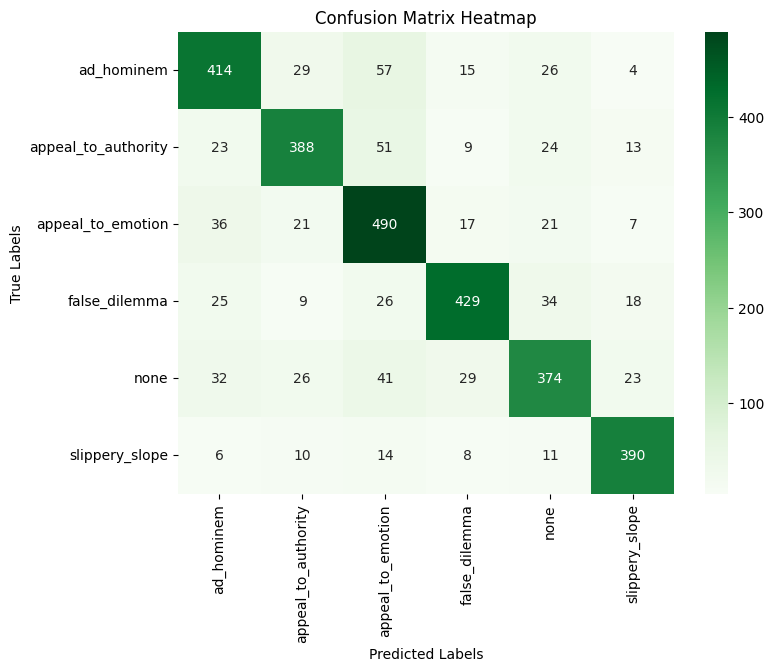

In [9]:
logger.info('get train metrics for one-step approach')
classification_report_one_train = get_metrics(y_train, y_train_pred_one)
log_metrics(classification_report_one_train, 'train')

2025-04-16 13:30:47,176: get test metrics for one-step approach
2025-04-16 13:30:47,177: classification_report
2025-04-16 13:30:47,204: confusion_matrix
2025-04-16 13:30:47,206: heatmap


                     precision    recall  f1-score   support

         ad_hominem       0.64      0.68      0.66       233
appeal_to_authority       0.67      0.61      0.64       218
  appeal_to_emotion       0.57      0.67      0.62       254
      false_dilemma       0.77      0.72      0.74       232
               none       0.54      0.49      0.51       225
     slippery_slope       0.74      0.71      0.72       188

           accuracy                           0.65      1350
          macro avg       0.65      0.65      0.65      1350
       weighted avg       0.65      0.65      0.65      1350

[[159  13  44   7   8   2]
 [ 19 133  28   4  26   8]
 [ 41  18 171   6  14   4]
 [  8   6  10 167  27  14]
 [ 18  24  33  20 110  20]
 [  3   6  12  13  20 134]]


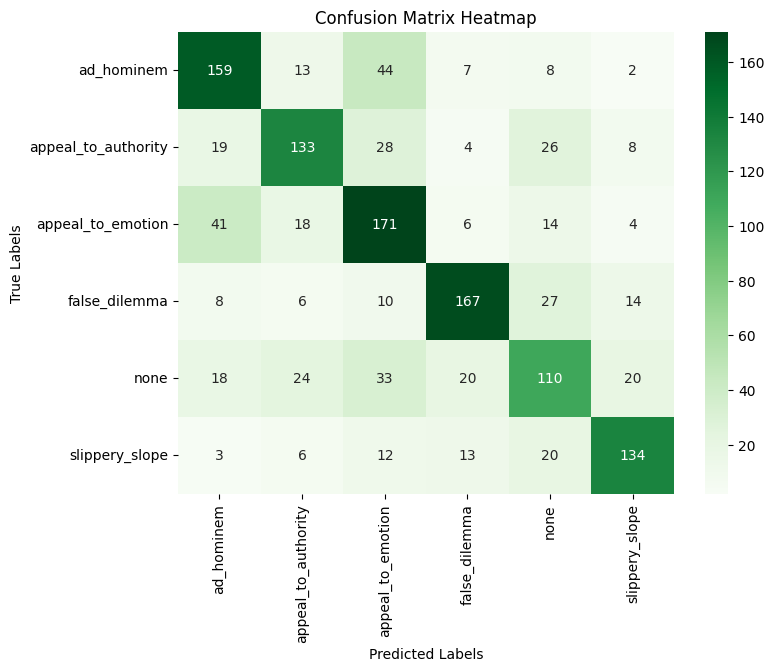

In [10]:
logger.info('get test metrics for one-step approach')
classification_report_one_test = get_metrics(y_test, y_test_pred_one)
log_metrics(classification_report_one_test, 'test')

In [11]:
mlflow.end_run()

🏃 View run LogReg Multiclass Large at: http://127.0.0.1:5001/#/experiments/823412171152425451/runs/454c25a1e9304f52827db49bcb3a694c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/823412171152425451
